
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# ディープ畳み込みニューラル ネットワーク (AlexNet)

 :label: `sec_alexnet`

 LeNet :cite: `LeCun.Jackel.Bottou.ea.1995`の導入後、CNN はコンピューター ビジョンと機械学習のコミュニティでよく知られるようになりましたが、すぐにこの分野を支配するようになったわけではありません。 LeNet は初期の小規模なデータセットで良好な結果を達成しましたが、より大規模でより現実的なデータセットで CNN をトレーニングするパフォーマンスと実現可能性はまだ確立されていませんでした。実際、1990 年代初頭から 2012 年の分水嶺の結果までの間のほとんどの期間 (引用: `Krizhevsky.Sutskever.Hinton.2012` :cite: Krizhevsky.Sutskever.Hinton.2012)、ニューラル ネットワークは、カーネル手法などの他の機械学習手法にしばしば追い越されました :cite: `Scholkopf.Smola.2002` 、アンサンブル手法:cite: `Freund.Schapire.ea.1996` 、および構造化推定:cite: `Taskar.Guestrin.Koller.2004` 。

コンピューター ビジョンの場合、この比較はおそらく完全には正確ではありません。つまり、畳み込みネットワークへの入力は生のピクセル値、または軽く処理された (たとえばセンタリングによって) ピクセル値で構成されますが、実務者は生のピクセルを従来のモデルにフィードすることはありません。代わりに、一般的なコンピューター ビジョン パイプラインは、SIFT :cite: `Lowe.2004` 、SURF :cite: `Bay.Tuytelaars.Van-Gool.2006` 、ビジュアル ワード :cite: `Sivic.Zisserman.2003` 。機能を*学習する*のではなく、機能を*作り上げた*のです。進歩のほとんどは、一方では特徴抽出のためのより賢いアイデアを持ち、他方では幾何学についての深い洞察から来ました:cite: `Hartley.Zisserman.2000` 。学習アルゴリズムは、後付けのものと考えられることがよくありました。

 1990 年代にはいくつかのニューラル ネットワーク アクセラレータが利用可能になりましたが、それらはまだ、多数のパラメータを持つ深いマルチチャネル、多層 CNN を作成するには十分に強力ではありませんでした。たとえば、1999 年の NVIDIA の GeForce 256 は、ゲーム以外の操作のための意味のあるプログラミング フレームワークがなくても、最大 4 億 8,000 万操作/秒 (MFLOP) を処理できました。現在のアクセラレータは、デバイスあたり 300 TFLOP を超えるパフォーマンスを実現できます (NVIDIA の Ampere A100)。 *FLOP は*乗算や加算などの浮動小数点演算であることに注意してください。さらに、データセットはまだ比較的小規模でした。60,000 枚の低解像度 $28 \× 28$ ピクセル画像の OCR は、非常に困難なタスクであると考えられていました。これらの障害に加えて、パラメーター初期化ヒューリスティックを含むニューラル ネットワークをトレーニングするための重要なトリックが追加されました :cite: `Glorot.Bengio.2010` 、確率的勾配降下法の巧妙な変種 :cite: `Kingma.Ba.2014` 、非潰し活性化関数 :cite: `Nair.Hinton.2010`と効果的な正則化テクニック :cite: `Srivastava.Hinton.Krizhevsky.ea.2014`はまだ見つかりませんでした。

したがって、古典的なパイプラインは、*エンドツーエンド*(ピクセルから分類) システムをトレーニングするのではなく、次のようになります。
1. 興味深いデータセットを取得します。初期の頃、これらのデータセットには高価なセンサーが必要でした。たとえば、1994 年の[Apple QuickTake 100 は、](https://en.wikipedia.org/wiki/Apple_QuickTake) 0.3 メガピクセル (VGA) という驚異的な解像度を備え、最大 8 枚の画像を保存でき、すべて 1,000 ドルの価格でした。
1. 光学、幾何学、その他の分析ツールの知識に基づいて、また時には幸運な大学院生の偶然の発見に基づいて、手作りの特徴量を使用してデータセットを前処理します。
1.  SIFT (スケール不変特徴変換) :cite: `Lowe.2004` 、 SURF (高速化された堅牢な特徴) :cite: `Bay.Tuytelaars.Van-Gool.2006`などの標準セットの特徴抽出器を通じてデータをフィードします。他の手動調整されたパイプラインはいくつでもあります。 OpenCV は現在でも SIFT エクストラクターを提供しています。
1. 結果の表現をお気に入りの分類器 (線形モデルまたはカーネル メソッドなど) にダンプして、分類器をトレーニングします。

機械学習の研究者と話をすると、彼らは機械学習は重要であり、美しいものであると信じていました。洗練された理論により、さまざまな分類器の特性が証明されました:cite: `Boucheron.Bousquet.Lugosi.2005`および凸最適化:cite: `Boyd.Vandenberghe.2004`が、それらを取得するための主力となっています。機械学習の分野は繁栄し、厳密で、非常に有用でした。しかし、コンピュータ ビジョンの研究者に話を聞くと、まったく異なる話が聞こえるでしょう。画像認識の汚い真実は、新しい学習アルゴリズムではなく、機能、 `Hartley.Zisserman.2000,hartley2009global` 、およびエンジニアリングが進歩を促進した、ということです。コンピューター ビジョンの研究者は、最終的な精度にとっては、どの学習アルゴリズムよりも、少し大きくなった、またはよりクリーンなデータセット、またはわずかに改善された特徴抽出パイプラインの方がはるかに重要であると正当に信じていました。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## 表現学習

状況を伝えるもう 1 つの方法は、パイプラインの最も重要な部分は表現であるということです。そして 2012 年までは、その表現はほとんど機械的に計算されていました。実際、一連の新しい特徴関数を設計し、結果を改善し、その方法を書き上げることは、論文の重要なジャンルでした。 SIFT :cite: `Lowe.2004` 、SURF :cite: `Bay.Tuytelaars.Van-Gool.2006` 、HOG (方向性勾配のヒストグラム) :cite: `Dalal.Triggs.2005` 、ビジュアルワードのバッグ :cite: `Sivic.Zisserman.2003` 、および同様の特徴抽出ツールがねぐらを支配していました。

ヤン・ルカン氏、ジェフ・ヒントン氏、ヨシュア・ベンジオ氏、アンドリュー・ン氏、甘利俊一氏、ユルゲン・シュミットフーバー氏を含む別の研究者グループは、異なる計画を立てていた。彼らは、特徴そのものを学ぶべきだと信じていました。さらに、彼らは、特徴を適度に複雑にするためには、それぞれが学習可能なパラメータを備えた複数の共同学習層で階層的に構成する必要があると考えました。画像の場合、動物の視覚システムが入力を処理する方法と同様に、最下層のレイヤーがエッジ、色、テクスチャを検出するようになります。特に、スパースコーディングによって得られるような視覚的特徴の自動設計 :cite: `olshausen1996emergence` 、最新の CNN が登場するまで未解決の課題のままでした。 :citet: `dean2012large,le2013building`になって初めて、画像データから特徴を生成するというアイデアが自動的に大きな注目を集めました。

最初の現代的な CNN :cite: `Krizhevsky.Sutskever.Hinton.2012` 、発明者の 1 人である Alex Krizhevsky にちなんで*AlexNet*と名付けられ、主に LeNet を進化させたものです。 2012 ImageNet チャレンジで優れたパフォーマンスを達成しました。 

![](../img/filters.png) :幅: `400px` :ラベル: `fig_filters`

興味深いことに、ネットワークの最下層では、モデルは従来のフィルターに似た特徴抽出器を学習しました。 :numref: `fig_filters`下位レベルの画像記述子を示します。ネットワークの上位層は、目、鼻、草の葉などのより大きな構造を表すために、これらの表現に基づいて構築される可能性があります。さらに上位のレイヤーでは、人、飛行機、犬、フリスビーなどのオブジェクト全体を表す場合があります。最終的に、最終的な隠れ状態は、さまざまなカテゴリに属する​​データを簡単に分離できるように、その内容を要約した画像のコンパクトな表現を学習します。

 AlexNet (2012) とその前身である LeNet (1995) は多くのアーキテクチャ要素を共有しています。ここで疑問が生じます。なぜこれほど時間がかかったのでしょうか?主な違いは、過去 20 年間で利用可能なデータとコンピューティング能力の量が大幅に増加したことです。そのため、AlexNet ははるかに大規模でした。1995 年に利用可能だった CPU と比較して、はるかに多くのデータとはるかに高速な GPU でトレーニングされました。

### 欠落している成分: データ

多くの層を持つ深いモデルは、凸型最適化に基づく従来の手法 (線形手法やカーネル手法など) を大幅に上回る領域に入るには、大量のデータを必要とします。しかし、コンピューターの限られたストレージ容量、（イメージング）センサーの相対的な費用、および 1990 年代の比較的厳しい研究予算を考慮すると、ほとんどの研究は小さなデータセットに依存していました。多くの論文が UCI のデータセット コレクションに依存していましたが、その多くには低解像度で撮影された数百または (数) 千の画像しか含まれておらず、多くの場合人工的にきれいな背景が付けられていました。

 2009 年に、ImageNet データセットがリリースされました (:cite: `Deng.Dong.Socher.ea.2009` )。これにより、研究者は 1000 万の例 (オブジェクトの 1000 の異なるカテゴリーからそれぞれ 1000 個) からモデルを学習することが求められました。カテゴリ自体は、WordNet で最も人気のある名詞ノードに基づいています (cite: `Miller.1995` )。 ImageNet チームは、Google 画像検索を使用して各カテゴリの大規模な候補セットを事前フィルタリングし、Amazon Mechanical Turk クラウドソーシング パイプラインを使用して、各画像が関連するカテゴリに属しているかどうかを確認しました。この規模は前例のないものであり、他の規模を一桁以上上回っています (たとえば、CIFAR-100 には 60,000 枚の画像があります)。もう 1 つの側面は、$32 \times 32$ ピクセルのサムネイルで構成される 8,000 万サイズの TinyImages データセット :cite: `Torralba.Fergus.Freeman.2008`とは異なり、画像が $224 \times 224$ ピクセルの比較的高解像度であることです。これにより、より高いレベルの機能の形成が可能になりました。 ImageNet Large Scale Visual Recognition Challenge :cite: `russakovsky2015imagenet`と名付けられた関連コンペは、コンピューター ビジョンと機械学習の研究を前進させ、研究者らに、学者がこれまで考えていたよりも大きな規模でどのモデルが最も優れたパフォーマンスを発揮するかを特定するよう求めました。 LAION-5B :cite: `schuhmann2022laion`などの最大の視覚データセットには、追加のメタデータを含む数十億の画像が含まれています。

### 不足している成分: ハードウェア

深層学習モデルは、コンピューティング サイクルを貪欲に消費します。トレーニングには数百のエポックがかかる場合があり、各反復では、計算コストのかかる線形代数演算の多くの層にデータを渡す必要があります。これが、1990 年代から 2000 年代初頭にかけて、より効率的に最適化された凸目標に基づく単純なアルゴリズムが好まれた主な理由の 1 つです。

*グラフィカル プロセッシング ユニット*(GPU) は、ディープ ラーニングの実現において大きな変革をもたらすことが証明されました。これらのチップは、コンピューター ゲームに利益をもたらすグラフィックス処理を高速化するために長い間開発されてきました。特に、多くのコンピュータ グラフィックス タスクに必要な、高スループットの $4 \times 4$ 行列ベクトル積向けに最適化されています。幸いなことに、この計算は畳み込み層の計算に必要な計算と驚くほど似ています。その頃、NVIDIA と ATI は、一般的なコンピューティング操作向けに GPU の最適化を開始し、*汎用 GPU* (GPGPU) として販売するまでに至りました :cite: `Fernando.2004` 。

直感的に理解するには、最新のマイクロプロセッサ (CPU) のコアを考えてみましょう。各コアは、高いクロック周波数で動作し、大規模なキャッシュ (L3 の最大数メガバイト) を備えているため、非常に強力です。各コアは、分岐予測機能、深いパイプライン、特殊な実行ユニット、投機的実行、および洗練された制御フローで多種多様なプログラムを実行できるようにするその他の多くの付加機能を備え、幅広い命令の実行に適しています。しかし、この見かけの強みはアキレス腱でもあります。汎用コアの製造コストは非常に高いのです。彼らは、多くの制御フローを含む汎用コードに優れています。これには、計算が行われる実際の ALU (算術論理演算装置) だけでなく、前述のすべての付加機能に加えて、メモリ インターフェイス、コア間のキャッシュ ロジック、高速相互接続などにも多くのチップ領域が必要です。 CPU は、専用ハードウェアと比較すると、単一タスクでは比較的苦手です。最近のラップトップには 4 ～ 8 コアがあり、ハイエンド サーバーであっても、コスト効率が悪いという理由だけで、ソケットあたり 64 コアを超えることはほとんどありません。

比較すると、GPU は数千の小さな処理要素 (NIVIDA の最新の Ampere チップには最大 6912 の CUDA コアが搭載されています) で構成されており、多くの場合、より大きなグループにグループ化されます (NVIDIA はこれをワープと呼んでいます)。詳細は、NVIDIA、AMD、ARM、およびその他のチップ ベンダー間で多少異なります。各コアは比較的弱く、約 1GHz のクロック周波数で動作しますが、GPU が CPU よりも桁違いに高速になるのは、そのようなコアの総数です。たとえば、NVIDIA の最近の Ampere A100 GPU は、特殊な 16 ビット精度 (BFLOAT16) の行列間乗算ではチップあたり 300 TFLOP を超え、より汎用的な浮動小数点演算 (FP32) では最大 20 TFLOP を提供します。同時に、CPU の浮動小数点パフォーマンスが 1 TFLOP を超えることはほとんどありません。たとえば、Amazon の Graviton 3 は、16 ビット精度の演算で 2 TFLOP のピーク パフォーマンスに達しており、この数値は Apple の M1 プロセッサの GPU パフォーマンスに似ています。

 FLOP の点で GPU が CPU よりもはるかに高速である理由はたくさんあります。まず、消費電力はクロック周波数に応じて*二次関数的に*増加する傾向があります。したがって、4 倍の速度で動作する CPU コアの電力バジェット (標準的な数値) では、$\frac{1}{4}$ の速度で 16 個の GPU コアを使用でき、$16 \times \frac{1 の利益が得られます。 {4} = 4$ 倍のパフォーマンス。第 2 に、GPU コアは非常にシンプルであるため (実際、長い間、汎用コードを実行することさえ*できませんでし*た)、エネルギー効率が高くなります。たとえば、(i) 投機的評価をサポートしない傾向があり、(ii) 通常、各処理要素を個別にプログラムすることが不可能であり、(iii) コアあたりのキャッシュがはるかに小さい傾向があります。最後に、深層学習の多くの操作では、高いメモリ帯域幅が必要です。ここでも、CPU の少なくとも 10 倍の幅を持つバスを備えた GPU が威力を発揮します。

 2012 年に戻ります。Alex Krizhevsky と Ilya Sutskever が GPU で実行できるディープ CNN を実装したときに、大きな進歩が起こりました。彼らは、CNN における計算のボトルネックである畳み込みと行列の乗算は、すべてハードウェアで並列化できる演算であることに気づきました。 3 GB のメモリを備えた 2 つの NVIDIA GTX 580 を使用し、どちらも 1.5​​ TFLOP の能力を備えており (10 年経った今でもほとんどの CPU にとって課題です)、高速コンボリューションを実装しました。 [cuda-convnet](https://code.google.com/archive/p/cuda-convnet/)コードは十分に優れていたため、数年間業界標準となり、深層学習ブームの最初の数年間を支えました。

## アレックスネット

8 層 CNN を採用した AlexNet は、ImageNet Large Scale Visual Recognition Challenge 2012 で大差で優勝しました (cite: `Russakovsky.Deng.Huang.ea.2013` )。このネットワークは、学習によって得られた特徴が手動で設計された特徴を超え、コンピューター ビジョンにおけるこれまでのパラダイムを打ち破ることができることを初めて示しました。

 :numref: `fig_alexnet`示すように、AlexNet と LeNet のアーキテクチャは驚くほど似ています。 2012 年にモデルを 2 つの小型 GPU に適合させるために必要だった設計の癖の一部を削除した、AlexNet のわずかに合理化されたバージョンを提供していることに注意してください。

![](http://d2l.ai/_images/alexnet.svg):ラベル: `fig_alexnet`

 AlexNet と LeNet の間には大きな違いもあります。まず、AlexNet は比較的小規模な LeNet5 よりもはるかに深いです。 AlexNet は、5 つの畳み込み層、2 つの完全接続された隠れ層、および 1 つの完全接続された出力層の 8 つの層で構成されます。第二に、AlexNet は活性化関数としてシグモイドの代わりに ReLU を使用しました。以下で詳しく見ていきましょう。

### 建築

AlexNet の最初の層では、畳み込みウィンドウの形状は $11\times11$ です。 ImageNet の画像は MNIST 画像の 8 倍高く、幅が広いため、ImageNet データ内のオブジェクトは、視覚的な詳細がより多くのピクセルを占める傾向があります。したがって、オブジェクトをキャプチャするには、より大きな畳み込みウィンドウが必要になります。 2 番目の層の畳み込みウィンドウの形状は $5\times5$ に縮小され、次に $3\times3$ に縮小されます。さらに、1 番目、2 番目、5 番目の畳み込み層の後に、ネットワークは $3\times3$ のウィンドウ形状と 2 のストライドを持つ最大プーリング層を追加します。さらに、AlexNet には LeNet の 10 倍の畳み込みチャネルがあります。

最後の畳み込み層の後には、4096 個の出力を持つ 2 つの巨大な完全接続層があります。これらのレイヤーには、約 1 GB のモデル パラメーターが必要です。初期の GPU ではメモリが限られていたため、オリジナルの AlexNet ではデュアル データ ストリーム設計が使用され、2 つの GPU のそれぞれがモデルの半分のみの保存と計算を担当できました。幸いなことに、GPU メモリは現在比較的豊富なので、最近では GPU 間でモデルを分割する必要はほとんどありません (この点で、AlexNet モデルのバージョンは元の論文から逸脱しています)。

### アクティベーション関数

さらに、AlexNet はシグモイド活性化関数をより単純な ReLU 活性化関数に変更しました。一方で、ReLU 活性化関数の計算はより簡単です。たとえば、シグモイド活性化関数にあるべき乗演算はありません。一方、ReLU 活性化関数を使用すると、さまざまなパラメーター初期化方法を使用する場合のモデルのトレーニングが容易になります。これは、シグモイド活性化関数の出力が 0 または 1 に非常に近い場合、これらの領域の勾配がほぼ 0 になるため、バックプロパゲーションが一部のモデル パラメーターを更新し続けることができないためです。対照的に、正の区間における ReLU 活性化関数の勾配は常に 1 (:numref: `subsec_activation-functions` ) です。したがって、モデル パラメーターが適切に初期化されていない場合、シグモイド関数は正の区間でほぼ 0 の勾配を取得し、モデルを効果的にトレーニングできなくなる可能性があります。

### 容量制御と前処理

AlexNet はドロップアウト (:numref: `sec_dropout` ) によって全結合層のモデルの複雑さを制御しますが、LeNet は重み減衰のみを使用します。データをさらに拡張するために、AlexNet のトレーニング ループには、反転、クリッピング、色の変更などの大量の画像拡張が追加されました。これにより、モデルがより堅牢になり、サンプルサイズが大きくなり、過剰適合が効果的に減少します。データ拡張については、 :numref: `sec_image_augmentation`で詳しく説明します。このような前処理ステップの詳細なレビューについては、:citet: `Buslaev.Iglovikov.Khvedchenya.ea.2020`も参照してください。


In [2]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)


高さと幅の両方が 224 の [**単一チャネル データの例を構築**] (**各レイヤーの出力形状を観察するため**)。これは、 :numref: `fig_alexnet`の AlexNet アーキテクチャと一致します。


In [3]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])


Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])


Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])


Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])



## トレーニング

AlexNet は :citet: `Krizhevsky.Sutskever.Hinton.2012`で ImageNet でトレーニングされましたが、ImageNet モデルを収束するまでトレーニングするには最新の GPU でも数時間から数日かかる可能性があるため、ここでは Fashion-MNIST を使用します。 [ **Fashion-MNIST** ] に AlexNet を直接適用する場合の問題の 1 つは、( **ImageNet 画像よりも****画像の解像度が低い) ($28 \times 28$ ピクセル) である**ことです。問題を解決するには、( **$224 \times にアップサンプリングします) 224ドル**）。これは、情報を追加せずに単に計算の複雑さを増大させるだけであるため、一般に賢明な実践とは言えません。それにもかかわらず、ここでは AlexNet アーキテクチャに忠実であるためにこのようにしています。このサイズ変更は、 `d2l.FashionMNIST`コンストラクターの`resize`引数を使用して実行します。

これで、[ **AlexNet のトレーニングを開始できます。** ] :numref: `sec_lenet`の LeNet と比較して、ここでの主な変更点は、より深く幅広いネットワーク、より高い画像解像度、およびよりコストのかかる畳み込みにより、学習率が低くなり、トレーニングが大幅に遅くなることです。


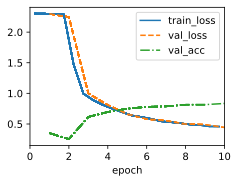

In [4]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)


## 議論

AlexNet の構造は LeNet に驚くほど似ており、精度 (ドロップアウト) とトレーニングの容易さ (ReLU) の両方において多くの重要な改善が加えられています。同様に驚くべきことは、ディープラーニングツールの面での進歩の量です。 2012 年には数か月かかった作業が、最新のフレームワークを使用すれば数十行のコードで実現できるようになりました。

アーキテクチャを確認すると、効率の点で AlexNet にはアキレス腱があることがわかります。最後の 2 つの隠れ層には、それぞれ $6400 \times 4096$ と $4096 \times 4096$ のサイズの行列が必要です。これは、164 MB のメモリと 81 MFLOP の計算に相当します。どちらも、特に携帯電話などの小型デバイスでは、少なからぬ出費となります。これが、AlexNet がより効率的なアーキテクチャに追い抜かれた理由の 1 つであり、これについては次のセクションで説明します。それにもかかわらず、これは、今日使用されている浅いネットワークから深いネットワークへの重要なステップです。パラメータの数が実験のトレーニング データの量をはるかに超えているにもかかわらず (最後の 2 つの層には 4,000 万を超えるパラメータがあり、6 万枚の画像のデータセットでトレーニングされています)、トレーニングと検証の過学習はほとんどないことに注意してください。損失は​​トレーニング全体を通じて実質的に同じです。これは、最新のディープ ネットワーク設計に固有の、ドロップアウトなどの正則化の改善によるものです。

 AlexNet の実装には LeNet の実装よりも数行多いだけのようですが、学術コミュニティがこの概念の変更を受け入れ、その優れた実験結果を活用するまでに何年もかかりました。これは効率的な計算ツールがなかったことも原因でした。当時、DistBelief :cite: `Dean.Corrado.Monga.ea.2012`も Caffe :cite: `Jia.Shelhamer.Donahue.ea.2014`も存在せず、Theano :cite: `Bergstra.Breuleux.Bastien.ea.2010`にはまだ多くの機能が欠けていました。際立った特徴。この状況を劇的に変えたのは、TensorFlow :cite: `Abadi.Barham.Chen.ea.2016`が利用可能になったことだけです。

## 演習
1. 上記の説明に続いて、AlexNet の計算特性を分析します。<ol><li>畳み込み層と完全接続層のそれぞれのメモリ フットプリントを計算します。どちらが優勢ですか？
1. 畳み込み層と全結合層の計算コストを計算します。
1. メモリ (読み取りおよび書き込み帯域幅、レイテンシ、サイズ) は計算にどのような影響を与えますか?トレーニングと推論の効果に違いはありますか?
1. 精度が大幅に低下しないようにしながら、トレーニングを高速化するためにモデルを単純化してみてください。
1.  $28 \times 28$ の画像で直接動作する、より優れたモデルを設計します。



[ディスカッション](https://discuss.d2l.ai/t/76)
